In [1]:
from DLtools.Data_preprocess import series_to_supervised,load_data,preprocess

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean()

DataFrame shape: (465169, 35)


# Preprocessing

In [30]:
X_in = df['CPY015_w']['2013-01-01':'2015-01-01'].interpolate(limit=7).values
X_in = X_in.astype('float32')

In [31]:
LOOKBACK=7

prep = preprocess(X_in,LOOKBACK,1)
train_X, train_Y = prep.train_X,prep.train_Y
val_X,val_y = prep.val_X,prep.val_y
test_X,test_y =prep.test_X,prep.test_Y

ori_trainX,ori_trianY = prep.ori_trainX,prep.ori_trainY

================================================== preview ==================================================
    var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
7    0.797222   0.636250   0.581458   0.532153   0.530139   0.294375   
8    0.636250   0.581458   0.532153   0.530139   0.294375   0.437708   
9    0.581458   0.532153   0.530139   0.294375   0.437708   0.343681   
10   0.532153   0.530139   0.294375   0.437708   0.343681   0.487361   
11   0.530139   0.294375   0.437708   0.343681   0.487361   0.643403   

    var1(t-1)   var1(t)  
7    0.437708  0.343681  
8    0.343681  0.487361  
9    0.487361  0.643403  
10   0.643403  0.689583  
11   0.689583  0.831286  
     var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
726   0.580347   0.692662   0.717910   0.483603   0.551702   0.656042   
727   0.692662   0.717910   0.483603   0.551702   0.656042   0.594748   
728   0.717910   0.483603   0.551702   0.656042   0.594748   0.464825   
729   0.4

# LSTM

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping


In [38]:
EPOCH = 100
BATCH = 7
VALIDATION = (val_X,val_y)

callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=2)
callbacks = [callback_early_stopping]

In [39]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(3, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(train_X, train_Y, epochs=EPOCH, batch_size=BATCH, verbose=1,shuffle=False,validation_data=VALIDATION,callbacks=callbacks)

Epoch 1/100
51/51 [==============================] - 1s 16ms/step - loss: 0.0513 - val_loss: 0.0228
Epoch 2/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0191 - val_loss: 0.0222
Epoch 3/100
51/51 [==============================] - 1s 12ms/step - loss: 0.0191 - val_loss: 0.0217
Epoch 4/100
51/51 [==============================] - 0s 9ms/step - loss: 0.0191 - val_loss: 0.0215
Epoch 5/100
51/51 [==============================] - 0s 9ms/step - loss: 0.0189 - val_loss: 0.0213
Epoch 6/100
51/51 [==============================] - 1s 13ms/step - loss: 0.0186 - val_loss: 0.0213
Epoch 7/100
51/51 [==============================] - 1s 13ms/step - loss: 0.0186 - val_loss: 0.0210
Epoch 8/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0184 - val_loss: 0.0208
Epoch 9/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0182 - val_loss: 0.0207
Epoch 10/100
51/51 [==============================] - 1s 12ms/step - loss: 0.0180 - val_loss: 0.0205
E

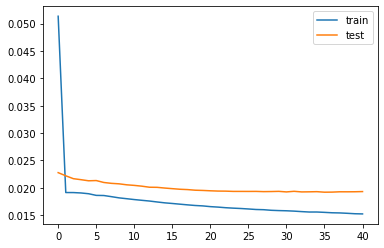

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [58]:
# generate predictions for training
trainPredict = model.predict(ori_trainX)
testPredict = model.predict(test_X)

print(len(trainPredict)+len(testPredict))
print(len(X_in))

724
731


In [11]:
#yhat = model.predict(test_X, verbose=0)
#yhat

In [43]:
# Estimate model performance
trainScore = model.evaluate(train_X,train_Y, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(test_X,test_y, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.02 MSE (0.12 RMSE)
Test Score: 0.03 MSE (0.18 RMSE)


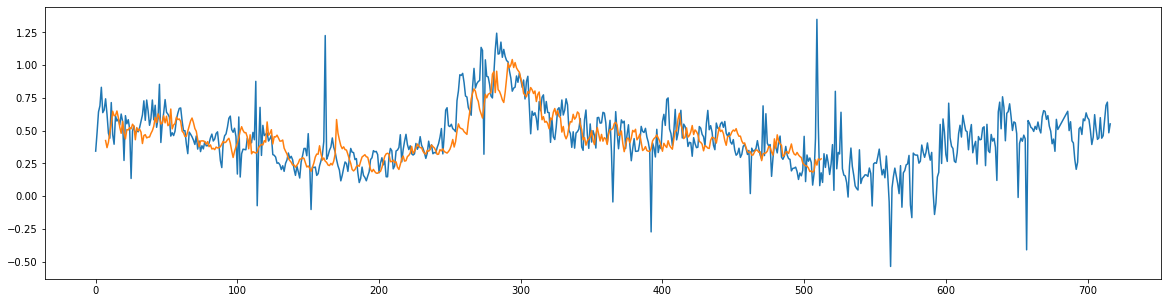

In [67]:
# # shift train predictions for plotting
trainPredictPlot = np.empty_like(X_in)
trainPredictPlot[:] = np.nan
trainPredictPlot = trainPredictPlot.reshape(-1,1)
trainPredictPlot[LOOKBACK:len(trainPredict)+LOOKBACK,:] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = np.empty_like(X_in)
# testPredictPlot[:] = np.nan
# testPredictPlot = testPredictPlot.reshape(-1,1)
# testPredictPlot[len(trainPredict)+(LOOKBACK*2)+1:len(X_in)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,5))
plt.plot(X_in[LOOKBACK:-LOOKBACK])
plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
plt.show()